### Project 7 

This project poses the question of how to improve the efficiency of many airports based on a number of variables leading into the airport, departure, and arrival. The goal is find what factors are most influential in optimizing an airports workflow. 

#### Step 1: Load the python libraries that you will need for this project 

In [87]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.stats import pearsonr, normaltest
import seaborn as sns
%matplotlib inline

#### Step 2: Examine your data 

The two datasets provided are airport_cancellations.csv and Airport_operations.csv. Both datasets have 'airport' and 'year' columns. The goal is to join both datasets on these columns to work more efficiently.

In [5]:
df_raw = pd.read_csv("/Users/lesliepham/Desktop/DSI_SM_01/projects/01-projects-weekly/project-07/assets/airport_cancellations.csv")
df = df_raw.dropna() 
df.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [4]:
df2_raw = pd.read_csv('/Users/lesliepham/Desktop/DSI_SM_01/projects/01-projects-weekly/project-07/assets/Airport_operations.csv')
df2 = df2_raw.dropna()
df2.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


### Intro: Write a problem statement / aim for this project

The goal is to understand the behavior and importance of factors of flight cancellations.


### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [14]:
import local as mypass

In [18]:
engine = create_engine('postgres://%s:%s@%s:%s/%s' % (mypass.user, mypass.password, mypass.host, mypass.port, mypass.dbname)) 


Load our csv files into tables

In [19]:
df.to_sql('table1', con=engine)

In [20]:
df2.to_sql('table2', con=engine)

Join airport_cancellations.csv and airports.csv into one table

In [54]:
query1=pd.read_sql('SELECT *FROM table1 LEFT JOIN table2\
                    ON table1."Year"=table2."year" AND table2."airport" = table1."Airport" ;',con=engine)
query1.head()

,index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,index,airport,year,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,0,ABQ,2004.0,242.0,235.0,71.0,46.0,0.0,ABQ,2004.0,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,1,ABQ,2005.0,221.0,190.0,61.0,33.0,1.0,ABQ,2005.0,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,2,ABQ,2006.0,392.0,329.0,71.0,124.0,2.0,ABQ,2006.0,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,3,ABQ,2007.0,366.0,304.0,107.0,45.0,3.0,ABQ,2007.0,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,4,ABQ,2008.0,333.0,300.0,79.0,42.0,4.0,ABQ,2008.0,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [53]:
airportdf = query1
del airportdf['Year']
del airportdf['Airport']
del airportdf['index']

In [116]:
del airportdf['departures for metric computation']
del airportdf['arrivals for metric computation']

Query the database for our intial data

In [117]:
pd.read_sql('SELECT * FROM table1', con=engine)

,index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,4,ABQ,2008.0,333.0,300.0,79.0,42.0
5,5,ABQ,2009.0,192.0,162.0,74.0,26.0
6,6,ABQ,2010.0,222.0,177.0,71.0,50.0
7,7,ABQ,2011.0,345.0,294.0,77.0,61.0
8,8,ABQ,2012.0,237.0,181.0,65.0,60.0
9,9,ABQ,2013.0,232.0,212.0,62.0,46.0


In [118]:
pd.read_sql('SELECT * FROM table2' , con= engine)

,index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,5,ABQ,2009,42550,42704,0.8341,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,6,ABQ,2010,42302,42169,0.8144,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,7,ABQ,2011,42283,42297,0.8072,0.7758,0.8022,10.81,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,8,ABQ,2012,39105,39107,0.8219,0.7940,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,9,ABQ,2013,35277,34989,0.7710,0.7402,0.7554,12.56,10.77,2.64,14.28,1.60,0.92,2.35,12.76


#### 1.2 What are the risks and assumptions of our data? 

Some risks and assumptions of the data are that the NaN values can be dropped without dramatically affecting the results of the analysis. I am also assuming that 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [153]:
airportdf.head()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,year,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,242.0,235.0,71.0,46.0,1,2004.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,221.0,190.0,61.0,33.0,1,2005.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,392.0,329.0,71.0,124.0,1,2006.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,366.0,304.0,107.0,45.0,1,2007.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,333.0,300.0,79.0,42.0,1,2008.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [120]:
airportdf.describe()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,year,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,805.000000,805.000000,805.000000,805.000000,805.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,1292.038509,1333.124224,173.315528,169.413665,36.838509,2009.016270,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,1835.961943,1975.224868,172.345539,228.521615,21.525555,3.150126,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,349.000000,314.000000,62.000000,41.000000,18.000000,2006.000000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,663.000000,642.000000,110.000000,84.000000,37.000000,2009.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,1472.000000,1523.000000,236.000000,190.000000,55.000000,2012.000000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,16618.000000,17571.000000,1064.000000,1948.000000,74.000000,2014.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


In [157]:
airportdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 17 columns):
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
airport                               805 non-null int64
year                                  799 non-null float64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne delay                799 non-null float64
average taxi in delay                 799 non-null float64
average bloc

In [121]:
airportdf1 = airportdf.dropna()

In [126]:
airportdf.airport.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55,  0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

#### Are there any unique values? 

yes there are 74 unique values for airports.

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [94]:
leAir = preprocessing.LabelEncoder()
airportdf1.airport = leAir.fit_transform(airportdf1.airport)

//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### 3.2 Format and Clean the Data

In [95]:
airportdf1.dtypes

Departure Cancellations               float64
Arrival Cancellations                 float64
Departure Diversions                  float64
Arrival Diversions                    float64
airport                                 int64
year                                  float64
departures for metric computation     float64
arrivals for metric computation       float64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
dtype: object

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [96]:
normaltest(airportdf1)

NormaltestResult(statistic=array([ 677.34396372,  672.85698189,  336.47828022,  540.32889134,
        526.74257131,  610.35370293,  223.19690471,  223.85879996,
        126.79779757,  139.0504605 ,  124.9829939 ,   45.2717115 ,
        295.08863972,  462.20657534,  194.81532975,  142.94812843,
        254.26970344,  110.95544514,  135.43205183]), pvalue=array([  8.25328995e-148,   7.77969961e-147,   8.60339396e-074,
         4.66736795e-118,   4.16201794e-115,   2.90654736e-133,
         3.41513560e-049,   2.45289651e-049,   2.92555386e-028,
         6.39110789e-031,   7.24916038e-028,   1.47697368e-010,
         8.36211330e-065,   4.29652570e-101,   4.97036921e-043,
         9.10349823e-032,   6.10991884e-056,   8.05992905e-025,
         3.90214685e-030]))

#### 4.2 Find correlations in the data

In [97]:
airportdf1.corr()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
Departure Cancellations,1.000000,0.997464,0.796385,0.792253,-0.167118,-0.074954,0.808959,0.809994,-0.183962,-0.466213,-0.113363,0.291753,0.566103,0.599671,0.504939,0.376828,0.723515,0.396928,0.325605
Arrival Cancellations,0.997464,1.000000,0.814378,0.793773,-0.165269,-0.071526,0.823676,0.824622,-0.172420,-0.453081,-0.094130,0.275300,0.559625,0.588159,0.487547,0.367273,0.730266,0.388365,0.305527
Departure Diversions,0.796385,0.814378,1.000000,0.840401,-0.165109,-0.021804,0.934147,0.934035,-0.051995,-0.357375,0.067575,0.124451,0.571622,0.554316,0.360954,0.280685,0.816581,0.330366,0.127359
Arrival Diversions,0.792253,0.793773,0.840401,1.000000,-0.181102,-0.035331,0.798750,0.799456,-0.142091,-0.431068,-0.028064,0.218199,0.558053,0.581730,0.444050,0.322749,0.785480,0.379282,0.219782
airport,-0.167118,-0.165269,-0.165109,-0.181102,1.000000,0.009206,-0.182136,-0.180795,0.068105,0.134896,0.002305,-0.134387,-0.146846,-0.141269,-0.170967,-0.166816,-0.171228,-0.047013,-0.099581
year,-0.074954,-0.071526,-0.021804,-0.035331,0.009206,1.000000,-0.068488,-0.067507,0.002818,0.056174,0.135191,0.061650,-0.052435,-0.160599,-0.023332,-0.334442,-0.031265,-0.321256,-0.064928
departures for metric computation,0.808959,0.823676,0.934147,0.798750,-0.182136,-0.068488,1.000000,0.999807,-0.063251,-0.399942,0.103680,0.131396,0.638656,0.604125,0.391838,0.401505,0.823040,0.358669,0.102899
arrivals for metric computation,0.809994,0.824622,0.934035,0.799456,-0.180795,-0.067507,0.999807,1.000000,-0.062713,-0.399040,0.104228,0.129871,0.636674,0.603439,0.390470,0.400179,0.822057,0.355442,0.101622
percent on-time gate departures,-0.183962,-0.172420,-0.051995,-0.142091,0.068105,0.002818,-0.063251,-0.062713,1.000000,0.818598,0.782703,-0.913107,-0.169598,-0.212539,-0.764464,-0.265446,-0.162607,-0.342640,-0.712282
percent on-time airport departures,-0.466213,-0.453081,-0.357375,-0.431068,0.134896,0.056174,-0.399942,-0.399040,0.818598,1.000000,0.695697,-0.826633,-0.653223,-0.725766,-0.954832,-0.558150,-0.495327,-0.561451,-0.753545


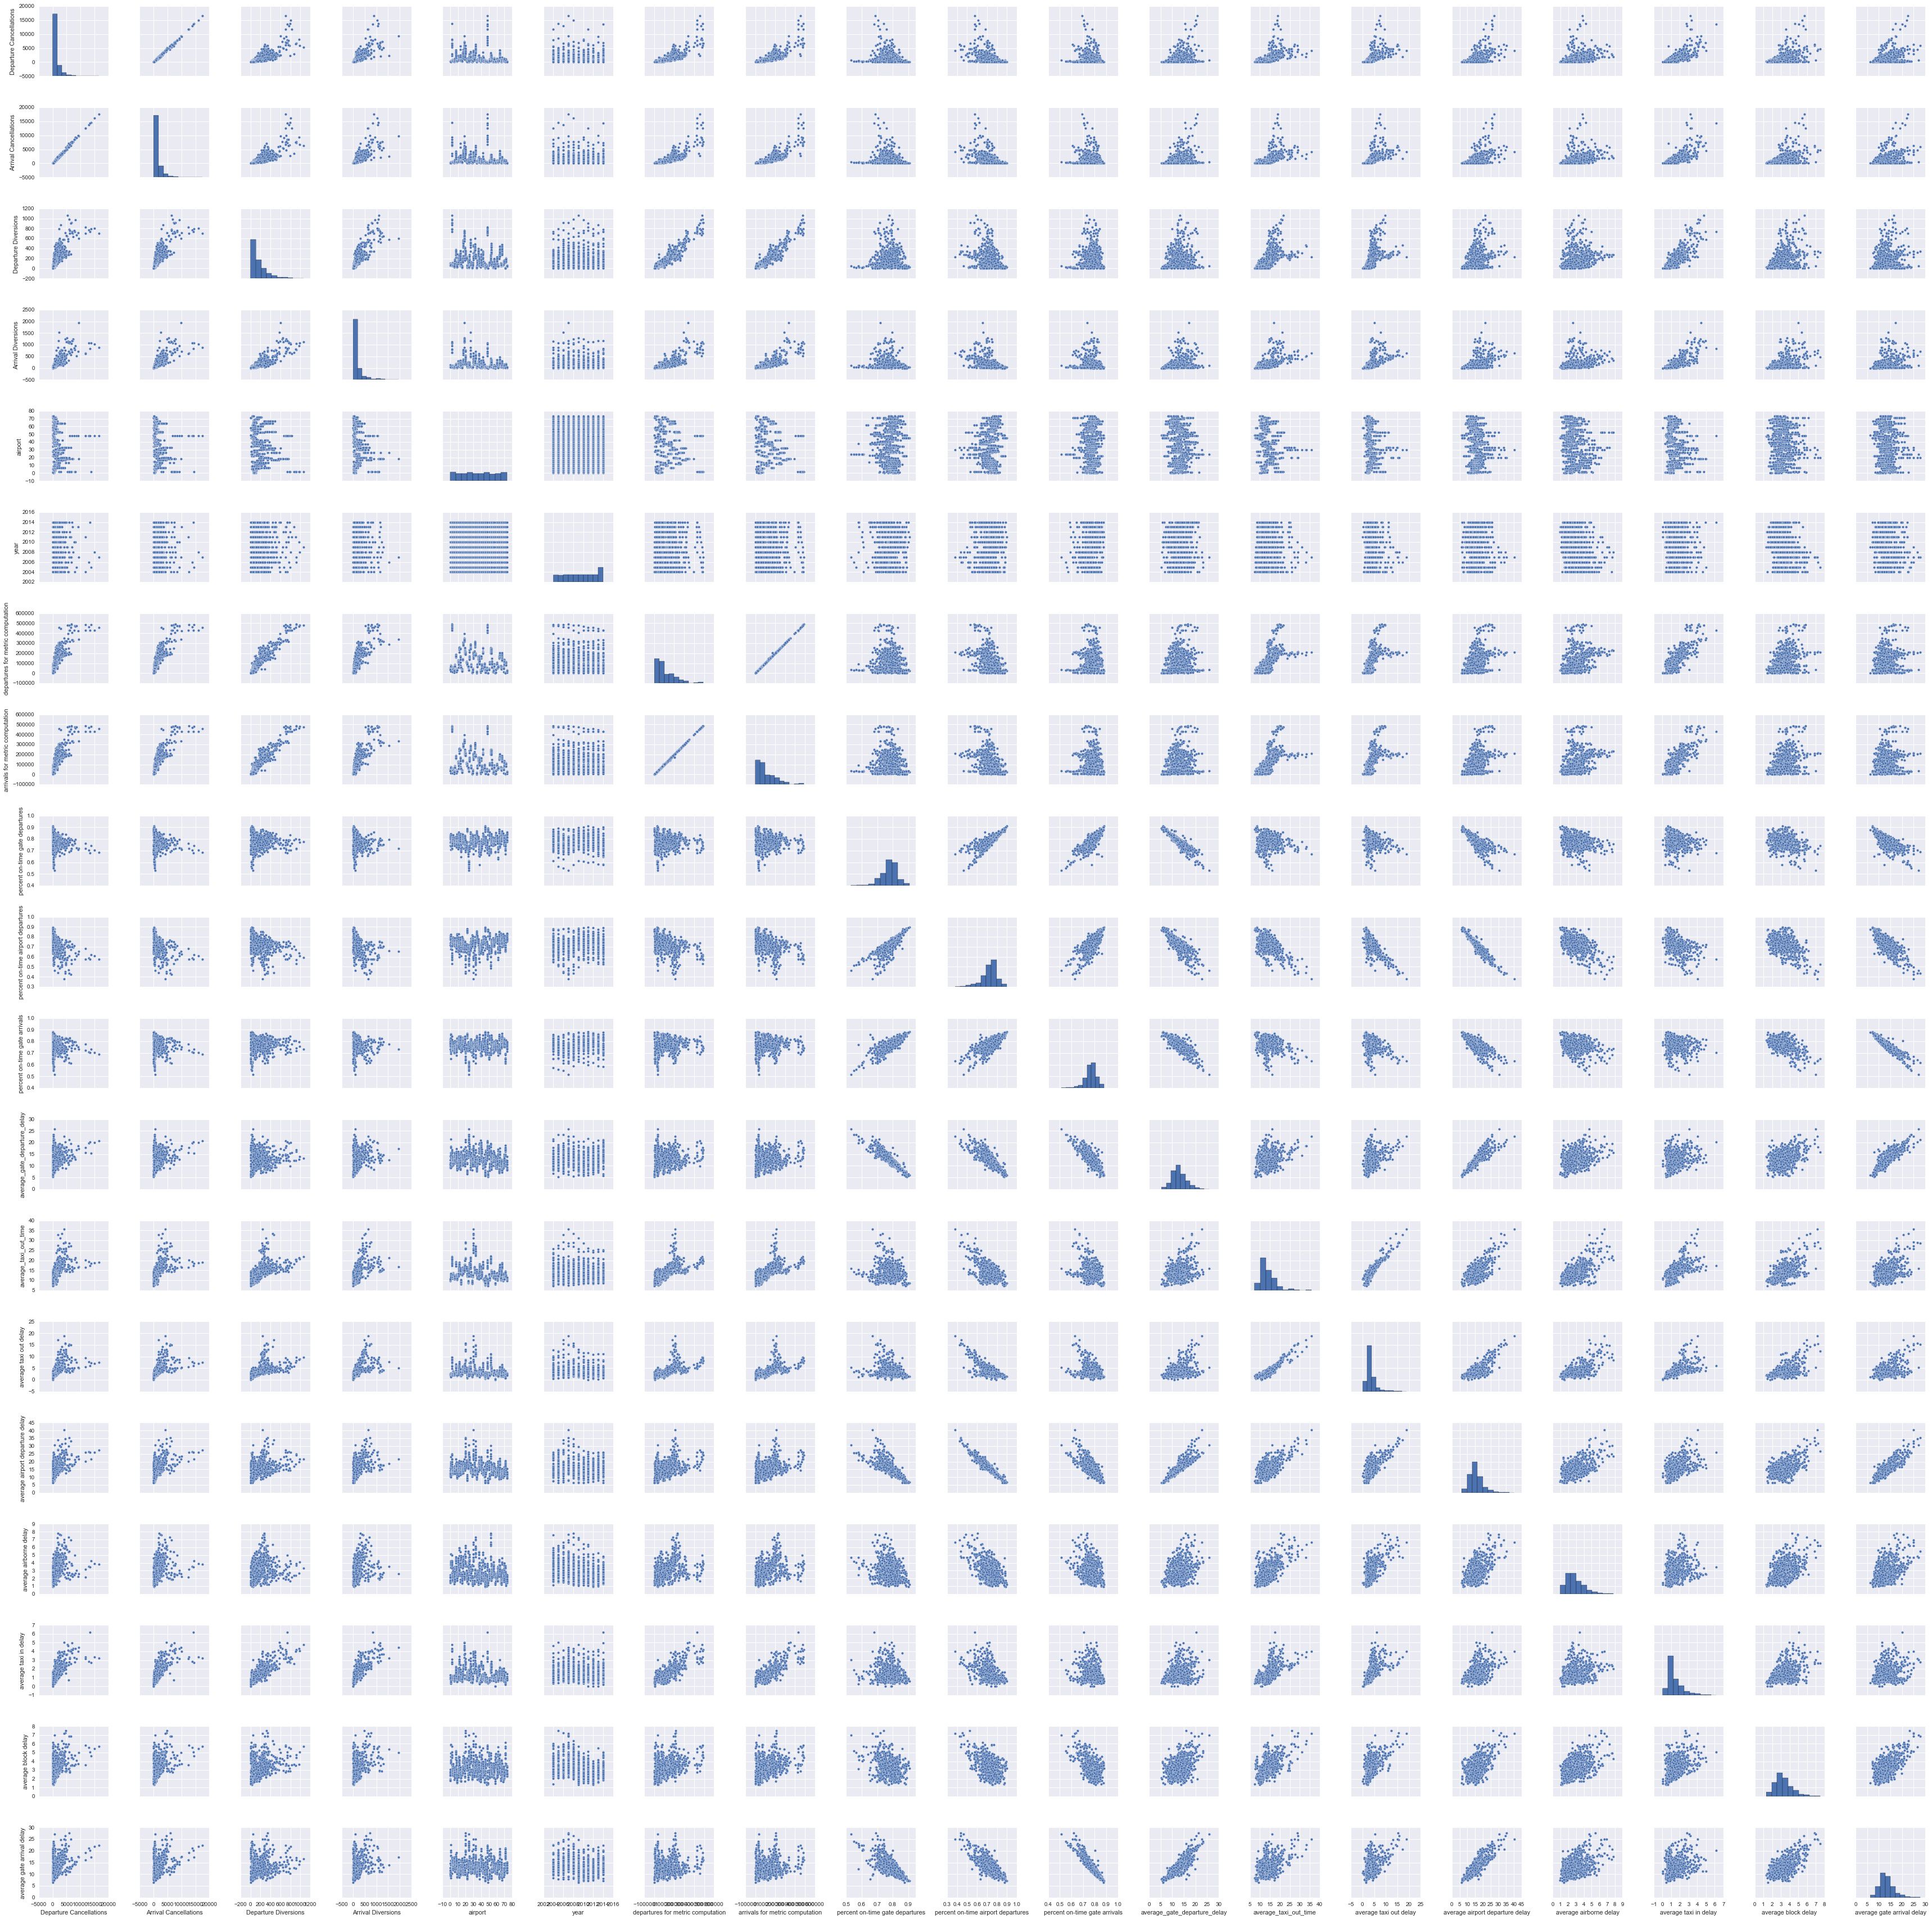

In [98]:
sns.pairplot(airportdf1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x1534c0dd0>],
 'caps': [<matplotlib.lines.Line2D at 0x14a55e250>,
 'fliers': [<matplotlib.lines.Line2D at 0x1251ec250>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x15c207090>],
 'whiskers': [<matplotlib.lines.Line2D at 0x14b2fef10>,
  <matplotlib.lines.Line2D at 0x1251ce950>]}

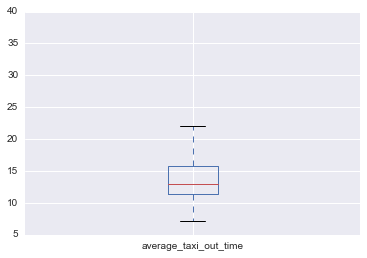

In [128]:
airportdf1.boxplot(column='average_taxi_out_time')

#### 4.3 What is the value of understanding correlations before PCA? 

The value of understanding correlation before PCA is to give a general idea of relationships between certain values before verifying the results using PCA. 

#### 4.4 Validate your findings using statistical analysis

In [ ]:
Refer to my (attempt of) PCA below.

#### 4.5 How can you improve your overall analysis? 

The analysis can be improved with using more models over more combinations of the variables besides the few I have chosen to use. 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [103]:
# Create a clean data frame 
ap1 = airportdf1[['airport','year','Departure Cancellations','Arrival Cancellations']]
ap1.head()

,airport,year,Departure Cancellations,Arrival Cancellations
0,0,2004.0,242.0,235.0
1,0,2005.0,221.0,190.0
2,0,2006.0,392.0,329.0
3,0,2007.0,366.0,304.0
4,0,2008.0,333.0,300.0


In [142]:
x = ap1.ix[:,1:].values
y = ap1.ix[:,0].values

In [143]:
X = preprocessing.StandardScaler().fit_transform(x)

In [144]:
covmat = np.cov(X.T)
eigenValues, eigenVectors = np.linalg.eig(covmat)

In [145]:
eigenValues

array([ 2.01062249,  0.99060376,  0.00253315])

In [146]:
eigenVectors

array([[ 0.1022064 , -0.99476022, -0.00244269],
       [-0.70349114, -0.07054347, -0.70719434],
       [-0.70331648, -0.0739982 ,  0.70701499]])

In [147]:
PCA_A = PCA(n_components=2)
Y = PCA_A.fit_transform(X)

In [148]:
Y

array([[ 0.63449181,  1.6669469 ],
       [ 0.69097824,  1.35345252],
       [ 0.60866148,  1.02571667],
       ..., 
       [ 0.98749931, -0.8513309 ],
       [ 0.98144012, -1.17125677],
       [ 1.01204775, -1.48742864]])

In [152]:
Ydf = pd.DataFrame(Y, columns=["PC1", "PC2"])
Ydf

,PC1,PC2
0,0.634492,1.666947
1,0.690978,1.353453
2,0.608661,1.025717
3,0.659953,0.711666
4,0.706459,0.397099
5,0.841879,0.091683
6,0.857543,-0.226010
7,0.801399,-0.551083
8,0.915317,-0.858699
9,0.938678,-1.175648


In [154]:
airports2 = airportdf[['airport', 'year']]

In [155]:
airport_pca = airports2.join(Ydf, on=None, how='left')

In [156]:
airport_pca

,airport,year,PC1,PC2
0,1,2004.0,0.634492,1.666947
1,1,2005.0,0.690978,1.353453
2,1,2006.0,0.608661,1.025717
3,1,2007.0,0.659953,0.711666
4,1,2008.0,0.706459,0.397099
5,1,2009.0,0.841879,0.091683
6,1,2010.0,0.857543,-0.226010
7,1,2011.0,0.801399,-0.551083
8,1,2012.0,0.915317,-0.858699
9,1,2013.0,0.938678,-1.175648


#### 5.2 Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

My findings show that many factors are correlated such as taxi delays, departure diversions, and the average gate departure delay. 

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset